In [2]:
import django
import pandas as pd
django.setup()

In [3]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from sch.models import *
import datetime as dt
from django.db.models import CharField
from django.test import RequestFactory
from sch.actions import *
from sch.views2 import *

In [6]:
shift = Shift.objects.get(name='EP')
all_mi_slots = list(Slot.objects.filter(shift=shift).values_list('employee__name',flat=True))
print(
    "All EP Slots\n",
    all_mi_slots
)

mi_tallies = tally(all_mi_slots)
print (
    "\n======TALLIES======\n",
    sortDict(mi_tallies)
)

All EP Slots
 ['Sabrina', 'David', 'David', 'Danica', 'Elisia', 'Sabrina', None, None, 'David', None, 'Brianna A', 'David', 'Sabrina', 'Trisha', 'Elisia', 'Elisia', 'Elisia', 'Esperanza', 'Elisia', 'Elisia', 'Tiffany', 'Sabrina', 'David', 'David', 'Mona', 'David', 'Trisha', 'Elisia', 'Josh', 'David', None, 'Jaden', 'David', 'Sabrina', 'Trisha', 'Tiffany', 'David', 'David', 'Mona', 'Elisia', 'Elisia', 'Elisia']

======TALLIES======
 {'Danica': 1, 'Brianna A': 1, 'Esperanza': 1, 'Josh': 1, 'Jaden': 1, 'Tiffany': 2, 'Mona': 2, 'Trisha': 3, None: 4, 'Sabrina': 5, 'Elisia': 10, 'David': 11}


In [7]:
df = pd.DataFrame.from_dict(sortDict(mi_tallies,reverse=True), orient='index', columns=['count'])
df

,count
David,11
Elisia,10
Sabrina,5
None,4
Trisha,3
Tiffany,2
Mona,2
Danica,1
Brianna A,1
Esperanza,1


array([<AxesSubplot:ylabel='count'>], dtype=object)

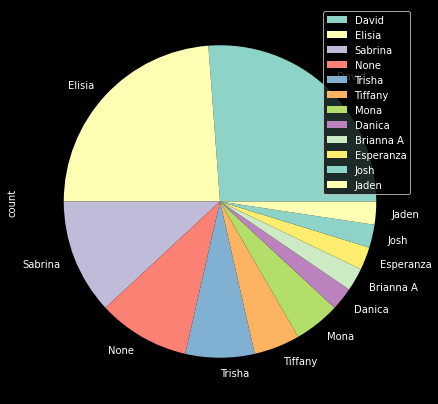

In [9]:
df.plot(kind='pie',subplots=True,figsize=(7,10))

In [23]:
sch = Schedule.objects.first()

empls = Employee.objects.annotate(scheduleHours=Sum('slots__shift__hours')).order_by('-scheduleHours')
# standard schedule Hours should be 240 * the employees fte field
empls = empls.annotate(standardScheduleHours=240*F('fte'))
empls = empls.annotate(percentScheduled=F('scheduleHours')/F('standardScheduleHours')*100)


<EmployeeManager [{'name': 'Elisia', 'percentScheduled': 108.33333333333333}, {'name': 'Jaden', 'percentScheduled': 104.16666666666667}, {'name': 'Brianna A', 'percentScheduled': 100.0}, {'name': 'Danica', 'percentScheduled': 100.0}, {'name': 'Michael', 'percentScheduled': 114.28571428571428}, {'name': 'Mona', 'percentScheduled': 100.0}, {'name': 'Tiffany', 'percentScheduled': 100.0}, {'name': 'Esperanza', 'percentScheduled': 95.83333333333334}, {'name': 'Cheryl', 'percentScheduled': 91.66666666666666}, {'name': 'David', 'percentScheduled': 91.66666666666666}, {'name': 'Josh', 'percentScheduled': 146.66666666666666}, {'name': 'Sabrina', 'percentScheduled': 141.66666666666669}, {'name': 'Trisha', 'percentScheduled': 114.99999999999999}, {'name': 'Amanda', 'percentScheduled': 57.14285714285714}, {'name': 'Leslie', 'percentScheduled': None}, {'name': 'Brittanie', 'percentScheduled': 43.333333333333336}, {'name': 'Lindsay', 'percentScheduled': None}]>